In [68]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nszoni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Import data

### Pre-covid conspiracy posts between 2016 and 2020

In [2]:
rc_precovid = pd.read_csv('../data/reddit_ct_2016_2020.csv')
rc_precovid.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"This rare image, featuring the victims of the ...",87129,cti1q4,https://i.redd.it/43kffo8bgth31.jpg,2768,1.566400e+09,NaN,2019-08-21 16:59:45
1,This was deleted twice from reddit's front page.,69819,88n2td,https://www.youtube.com/watch?v=hWLjYJ4BzvI&fe...,2124,1.522543e+09,NaN,2018-04-01 02:44:34
2,REMINDER: It has been 2866 days since Sean Han...,46610,5w55ai,http://crooksandliars.com/2016/04/today-comple...,1414,1.488044e+09,NaN,2017-02-25 18:26:06
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,dophtr,https://i.redd.it/1wrdlnwsahv31.png,1644,1.572354e+09,NaN,2019-10-29 14:03:25
4,Do you remember?,39199,g5cmiw,https://i.redd.it/l4iu3ot7c5u41.jpg,1078,1.587464e+09,NaN,2020-04-21 12:14:48


### Post-covid top conspiracy post in the last year

In [3]:
rc_postcovid = pd.read_csv('../data/reddit_ct_2021_2022.csv')
rc_postcovid.head()

,title,score,id,url,comms_num,created,body,timestamp
0,The true conspiracy that is happening in broad...,25705,okyu6g,https://i.redd.it/dozjrgtf6fb71.png,1590,1.626374e+09,NaN,2021-07-15 20:29:45
1,Yesterday The Atlantic put out an article clai...,18557,rdg5q3,https://i.redd.it/mlegrm1ulr481.jpg,1642,1.639164e+09,NaN,2021-12-10 20:15:33
2,"Welcome to 2021, where multi billion dollar oi...",17604,o9w3t8,https://i.postimg.cc/bvR2DsPd/Ll85ILeM.png,481,1.624923e+09,NaN,2021-06-29 01:29:38
3,The worst shitcoin.,16377,ngdq1r,https://i.redd.it/8y5c8drwh4071.png,883,1.621450e+09,NaN,2021-05-19 20:47:55
4,Newly released photos show Maxwell and Epstein...,16159,rc13h3,https://i.redd.it/okfldphnwd481.jpg,1961,1.638998e+09,NaN,2021-12-08 22:11:16


## Data Cleaning

In [36]:
# Label dataframes and union

rc_precovid['label'] = 'precovid'
rc_postcovid['label'] = 'postcovid'

rc = pd.concat([rc_precovid, rc_postcovid], axis=0)

#drop unused columns


rc.head()

,title,score,id,url,comms_num,created,body,timestamp,label
0,"This rare image, featuring the victims of the ...",87129,cti1q4,https://i.redd.it/43kffo8bgth31.jpg,2768,1.566400e+09,NaN,2019-08-21 16:59:45,precovid
1,This was deleted twice from reddit's front page.,69819,88n2td,https://www.youtube.com/watch?v=hWLjYJ4BzvI&fe...,2124,1.522543e+09,NaN,2018-04-01 02:44:34,precovid
2,REMINDER: It has been 2866 days since Sean Han...,46610,5w55ai,http://crooksandliars.com/2016/04/today-comple...,1414,1.488044e+09,NaN,2017-02-25 18:26:06,precovid
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,dophtr,https://i.redd.it/1wrdlnwsahv31.png,1644,1.572354e+09,NaN,2019-10-29 14:03:25,precovid
4,Do you remember?,39199,g5cmiw,https://i.redd.it/l4iu3ot7c5u41.jpg,1078,1.587464e+09,NaN,2020-04-21 12:14:48,precovid


In [37]:
rc.drop(['id', 'url', 'comms_num', 'created'], axis=1, inplace=True)

rc.head()

,title,score,body,timestamp,label
0,"This rare image, featuring the victims of the ...",87129,NaN,2019-08-21 16:59:45,precovid
1,This was deleted twice from reddit's front page.,69819,NaN,2018-04-01 02:44:34,precovid
2,REMINDER: It has been 2866 days since Sean Han...,46610,NaN,2017-02-25 18:26:06,precovid
3,"Reminder: 80 days ago a Billionaire pedophile,...",41180,NaN,2019-10-29 14:03:25,precovid
4,Do you remember?,39199,NaN,2020-04-21 12:14:48,precovid


## Text Processing

In [44]:
# Separate to title and body
title_data = rc[['title','timestamp','label']].copy()
body_data = rc[['body','timestamp','label']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()

#Cast timestamp to date
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date
body_data.timestamp = pd.to_datetime(body_data.timestamp).dt.date

#### Extend stopwords corpus

In [81]:
#add words to stopword list
stop_words = stopwords.words('english')
stop_words.extend(['use', 'people', 'person', 'like', 'think', 'know', 'case', 'want',
                   'mean', 'one', 'many', 'well', 'two', 'say', 'would', 'make', 'get', 'go', 'thing', 'much', ])

In [39]:
lemmatizer = WordNetLemmatizer()

def text_preprocess_lemmatize(text: str) -> str:
    
    '''
    - remove handlers (eg. @username)
    - remove urls
    - remove any non-word elements (inc. punctuation)
    - remove single letters
    - remove digits
    - replace multiple spaces with a single space
    - tokenize text
    - filter out stopwords
    - lemmatize tokens
    - filter out tokens with less than 3 characters
    '''
    garbage = re.compile('@[^\s]+|http\S+|\W|\s+[a-zA-Z]\s+|\d+|\s+')
    
    text = text.lower()
    text= re.sub(garbage,' ', text)
    
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in set(stopwords.words('english'))]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [word for word in tokens if len(word)>=3]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [45]:
body_data['cleaned'] = body_data['body'].apply(text_preprocess_lemmatize)

In [46]:
body_data.head()

,body,timestamp,label,cleaned
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule


In [47]:
#drop rows where cleaned is null
body_data['cleaned'].replace('', np.nan, inplace=True)
body_data = body_data[body_data['cleaned'].notna()]

## Feature Engineering

In [48]:
# Apply SIA from Vader package

sid = sia()
body_data['sentiments'] = body_data['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [43]:
body_data.head()

,body,timestamp,cleaned,sentiments
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com..."
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co..."
96,A ring was just brought down in Florida and ba...,2019-02-22,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp..."
104,"Reposted due to ""violation of rule 6""",2017-07-12,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou..."


In [49]:
# Parse out dict elements

body_data['positive'] = body_data['sentiments'].apply(lambda x: x['pos']) 
body_data['neutral'] = body_data['sentiments'].apply(lambda x: x['neu'])
body_data['negative'] = body_data['sentiments'].apply(lambda x: x['neg'])
body_data['compound'] = body_data['sentiments'].apply(lambda x: x['compound'])

In [50]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939


We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. There's some testing and experimentation that goes with choosing these ranges, and there is a trade-off to be made here. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

Let's create a positive label of 1 if the compound is greater than 0.2, and a label of -1 if compound is less than -0.2. Everything else will be 0.

In [51]:
THRESHOLD = 0.2

conditions = [
    (body_data['compound'] <= -THRESHOLD),
    (body_data['compound'] > -THRESHOLD) & (body_data['compound'] < THRESHOLD),
    (body_data['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
body_data['sentiment'] = np.select(conditions, values)

In [52]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound,sentiment
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875,neg
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994,pos
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124,pos
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939,neg


### Feature Extraction

In [53]:
body_data['num_words'] = body_data['body'].apply(lambda x: len(x.split(' ')))
body_data['num_stopwords'] = body_data['body'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
body_data['avg_word_length'] = body_data['body'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))

In [92]:
body_data.head()

,body,timestamp,label,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length
49,"Yesterday, a [link to South Park's latest epis...",2019-10-08,precovid,yesterday link south park latest episode band ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu,91,30,23.262295
75,This needs to be said.\n\nEdit: to all those w...,2017-03-29,precovid,need said edit think still trump supporter kno...,"{'neg': 0.19, 'neu': 0.726, 'pos': 0.084, 'com...",0.084,0.726,0.190,-0.9875,neg,208,101,7.663551
95,"Well, I didn’t get much sleep and [posting thi...",2019-08-16,precovid,well get much sleep posting recommendation doc...,"{'neg': 0.063, 'neu': 0.841, 'pos': 0.096, 'co...",0.096,0.841,0.063,0.9994,pos,4634,1802,6.685734
96,A ring was just brought down in Florida and ba...,2019-02-22,precovid,ring brought florida based good intel certain ...,"{'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...",0.217,0.783,0.000,0.6124,pos,22,9,4.923077
104,"Reposted due to ""violation of rule 6""",2017-07-12,precovid,reposted due violation rule,"{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compou...",0.000,0.610,0.390,-0.4939,neg,7,2,5.400000


## EDA

### Distributions

### Do people write lenghty posts after COVID?

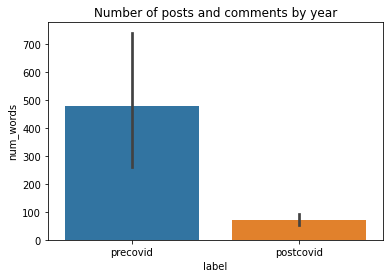

In [91]:
sns.barplot(x='label', y='num_words', data=body_data)
plt.title('Number of posts and comments by year')
plt.show()

### Distribution of sentiment categories

In [96]:
body_data.label.value_counts()

postcovid    1088
precovid       58
Name: label, dtype: int64

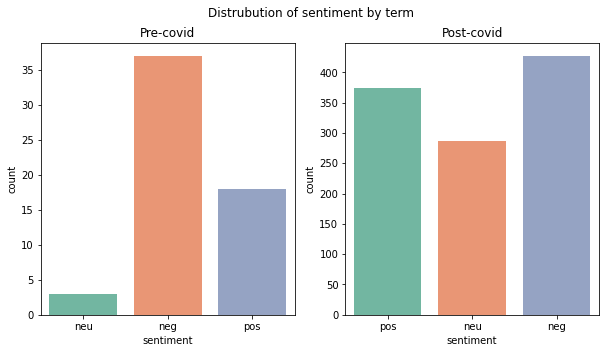

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Distrubution of sentiment by term')

# Pre-covid
sns.countplot(ax=axes[0], x='sentiment', data=body_data[body_data['label']=='precovid'], palette='Set2')
axes[0].set_title('Pre-covid')

# Post-covid
sns.countplot(ax=axes[1], x='sentiment', data=body_data[body_data['label']=='postcovid'], palette='Set2')
axes[1].set_title('Post-covid')

plt.show()

Text(0.5, 1.0, 'Negative')

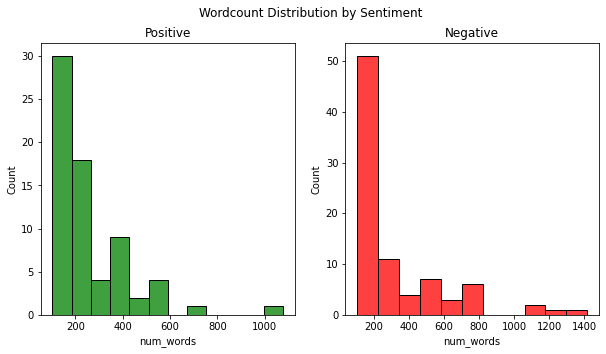

In [111]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Wordcount Distribution by Sentiment')


sns.histplot(body_data[(body_data['sentiment']=='pos') & (body_data['num_words'] > 100) & (body_data['num_words'] < 2000)]['num_words'], ax=axes[0],color='green')
axes[0].set_title('Positive')

sns.histplot(body_data[(body_data['sentiment']=='neg') & (body_data['num_words'] > 100) & (body_data['num_words'] < 2000)]['num_words'], ax=axes[1],color='red')
axes[1].set_title('Negative')

### Time based analysis

In [63]:
#Sorting And Feature Engineering
rc_ts = body_data.sort_values(by='timestamp')
rc_ts=rc_ts.copy()
rc_ts = rc_ts.rename(columns={'timestamp':'date'})
rc_ts['year']         = pd.DatetimeIndex(rc_ts['date']).year
rc_ts['month']        = pd.DatetimeIndex(rc_ts['date']).month
rc_ts['day']          = pd.DatetimeIndex(rc_ts['date']).day
rc_ts['day_of_year']  = pd.DatetimeIndex(rc_ts['date']).dayofyear
rc_ts['quarter']      = pd.DatetimeIndex(rc_ts['date']).quarter
rc_ts['season']       = rc_ts.month%12 // 3 + 1

In [64]:
rc_ts.head()

,body,date,label,cleaned,sentiments,positive,neutral,negative,compound,sentiment,num_words,num_stopwords,avg_word_length,year,month,day,day_of_year,quarter,season
156,[Not Appropriate Subreddit](https://www.reddit...,2016-01-05,precovid,appropriate subreddit appropriate subreddit ap...,"{'neg': 0.143, 'neu': 0.812, 'pos': 0.045, 'co...",0.045,0.812,0.143,-0.9963,neg,30,3,156.740741,2016,1,5,5,1,1
421,"German journalist Richard Gutjahr, 42, who fil...",2016-07-23,precovid,german journalist richard gutjahr filmed scene...,"{'neg': 0.161, 'neu': 0.776, 'pos': 0.063, 'co...",0.063,0.776,0.161,-0.9648,neg,125,41,9.333333,2016,7,23,205,3,3
653,"After the Wikileaks emails, and Schultz's resi...",2016-08-02,precovid,wikileaks email schultz resignation think need...,"{'neg': 0.129, 'neu': 0.871, 'pos': 0.0, 'comp...",0.000,0.871,0.129,-0.7184,neg,60,25,6.571429,2016,8,2,215,3,3
370,They even sent billions to the Middle East lat...,2016-09-14,precovid,even sent billion middle east lately money nee...,"{'neg': 0.027, 'neu': 0.929, 'pos': 0.044, 'co...",0.044,0.929,0.027,0.3400,pos,143,59,6.011905,2016,9,14,258,3,4
371,This sub has pretty much been dominated with a...,2016-11-01,precovid,sub pretty much dominated anti clinton story n...,"{'neg': 0.05, 'neu': 0.786, 'pos': 0.164, 'com...",0.164,0.786,0.050,0.9589,pos,146,72,5.675676,2016,11,1,306,4,4


In [ ]:
sns.countplot(x='year', data=rc_ts)
plt.title('Number of posts and comments by year')
plt.show()

## Sentiment Analysis

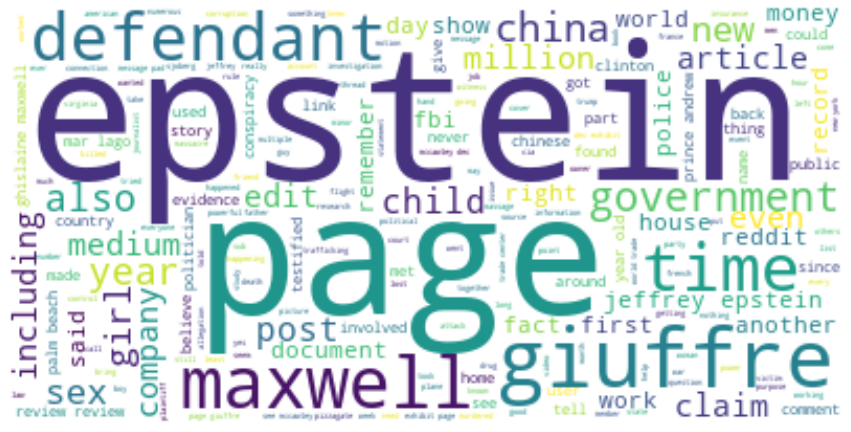

In [83]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
precovid_wc = body_data[body_data['label'] == 'precovid']
body_words = ''
for sentence in precovid_wc['cleaned']:
    body_words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(body_words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

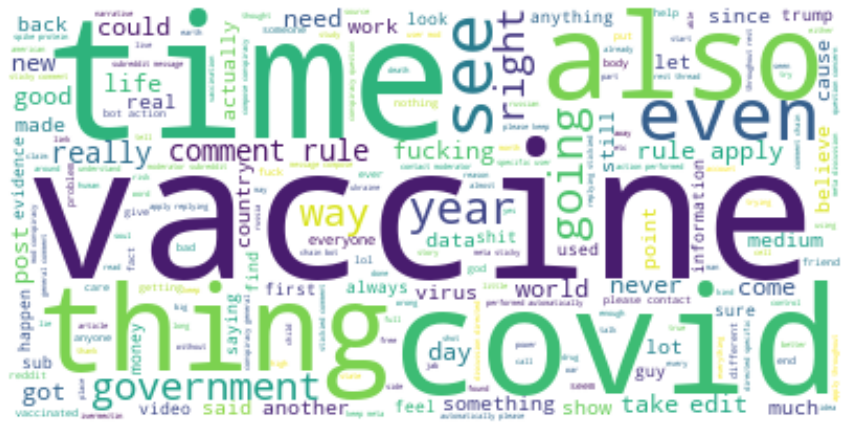

In [84]:
# Iterate through body column to join the text in all rows
# filter for pre-covid data
postcovid_wc = body_data[body_data['label'] == 'postcovid']
body_words = ''
for sentence in postcovid_wc['cleaned']:
    body_words += str(sentence) + ' '

# Create and generate a word cloud image 
my_cloud = WordCloud(background_color='white', stopwords=stop_words, max_words=200).generate(body_words)

# Display the generated wordcloud image
plt.figure(figsize=(15,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

## Topic Modelling